In [2]:
import pytorch_lightning as pl
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from models.autoencoder import Autoencoder
from data.hmaps import OODMaps
from modules.planners import DifferentiableDiagAstar

from neural_astar.planner import NeuralAstar
from neural_astar.utils.training import load_from_ptl_checkpoint

import os

pl.seed_everything(42)

device = 'cuda'

Global seed set to 42


In [11]:
#some preparations

model_cf = Autoencoder(mode='k')
model_focal = Autoencoder(mode='f')
neural_astar = NeuralAstar(encoder_arch='CNN')



ckpt_path = os.path.abspath("neural-astar/model/mazes_032_moore_c8/lightning_logs/version_0/")
neural_astar.load_state_dict(load_from_ptl_checkpoint(ckpt_path))
model_cf.load_state_dict(torch.load('./weights/cf.pth'))
model_focal.load_state_dict(torch.load('custom_weights/epoch=17.pth'))



model_cf.eval()
model_focal.eval()

data = OODMaps(xml_path='./maps')
dataloader = DataLoader(data, batch_size=len(data),
                        shuffle=False, num_workers=0, pin_memory=False)
samples = next(iter(dataloader))

map_design, start, goal, hm, koefs, h = samples
inputs_g = torch.cat([map_design, goal], dim=1)
inputs_sg = torch.cat([map_design, start + goal], dim=1)

f_planner = DifferentiableDiagAstar(mode='f')
fw100_planner = DifferentiableDiagAstar(mode='f', f_w=100)
cf_planner = DifferentiableDiagAstar(mode='k')
w2_planner = DifferentiableDiagAstar(mode='default', h_w=2)
vanilla_planner = DifferentiableDiagAstar(mode='default', h_w=1)


load /home/dan/TransPath/neural-astar/model/mazes_032_moore_c8/lightning_logs/version_0/checkpoints/epoch=33-step=272.ckpt


In [12]:
#get predictions and plan results

with torch.no_grad():
    pred_f = (model_focal(inputs_sg) + 1) / 2
    pred_cf = (model_cf(inputs_g) + 1) / 2
    pred_na = neural_astar(
        (map_design==0),
        start,
        goal
    )
    outputs_cf = cf_planner(
                    pred_cf,
                    start,
                    goal,
                    (map_design == 0)*1.)
    
    outputs_fw100 = fw100_planner(
                    pred_f,
                    start,
                    goal,
                    (map_design == 0)*1.)

    outputsw2 = w2_planner(
                    (map_design == 0)*1.,
                    start,
                    goal,
                    (map_design == 0)*1.)
    
    outputs_vanilla = vanilla_planner(
                    (map_design == 0)*1.,
                    start,
                    goal,
                    (map_design == 0)*1.)


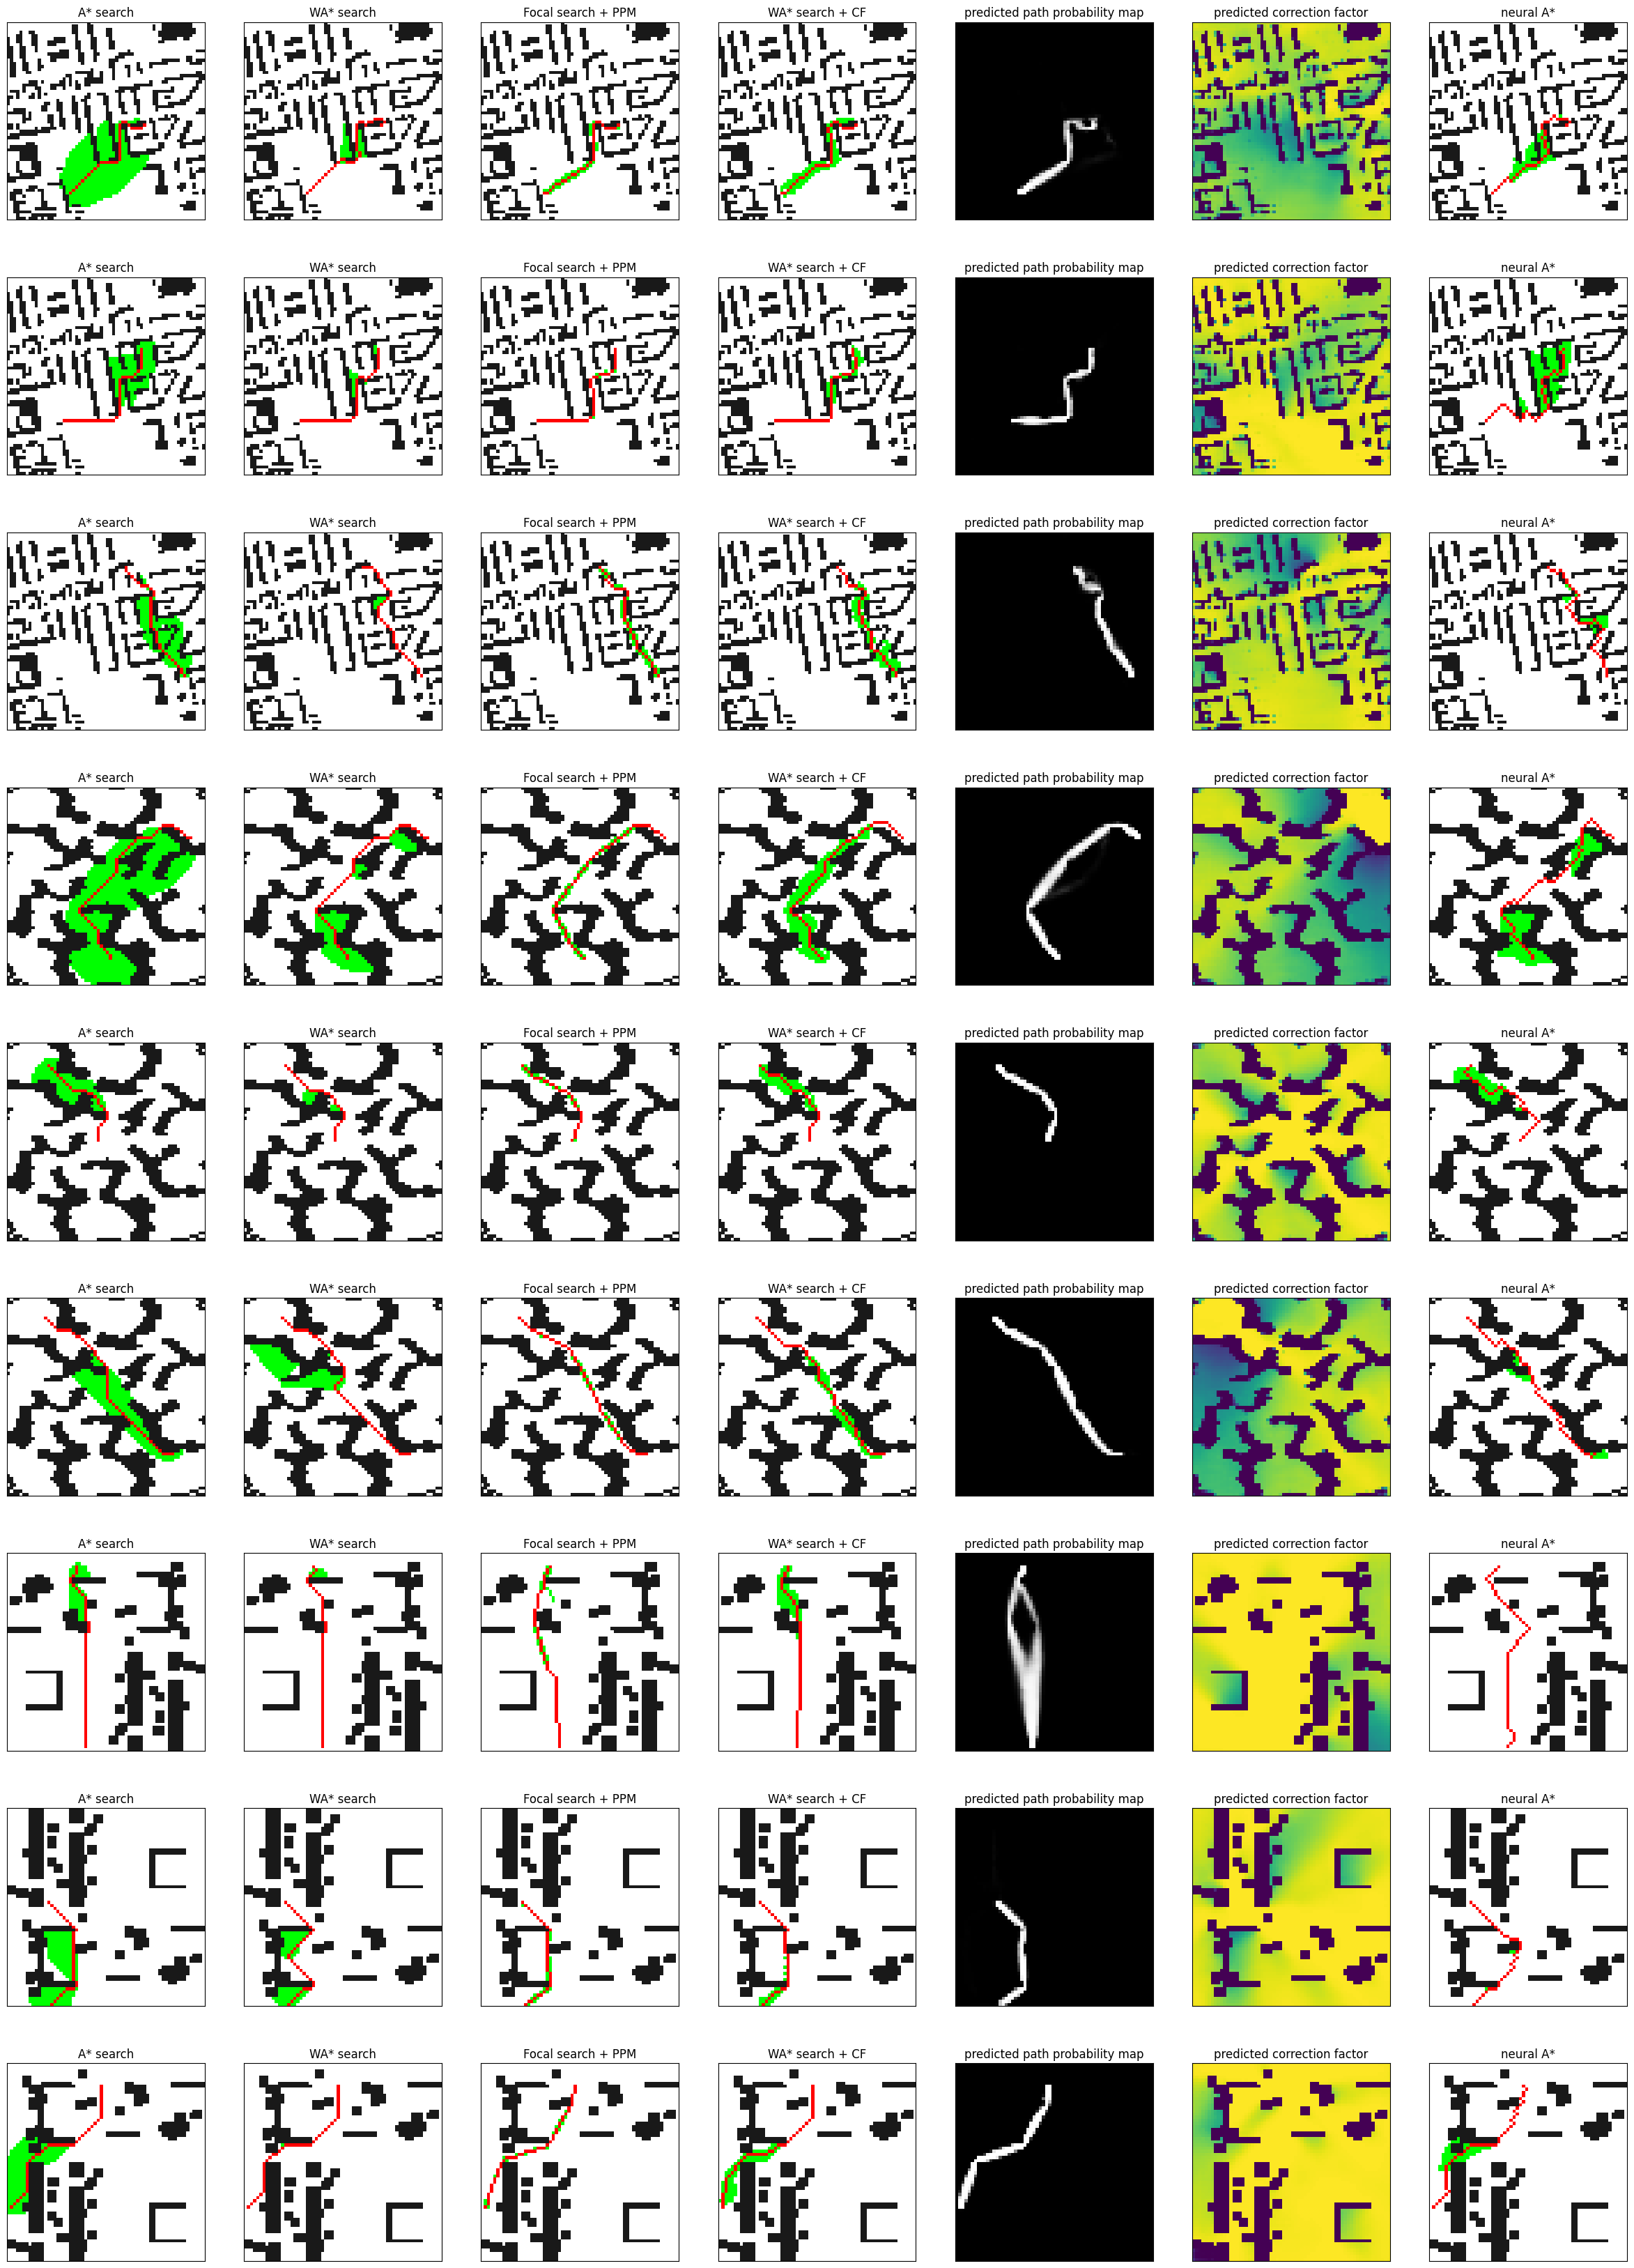

In [17]:
#results visualisation

def transform_plan(image):
    result = torch.ones_like(image)
    result[image[:, :, 0] == 1] = torch.tensor([0.1, 0.1, 0.1])
    result[image[:, :, 1] == 1] = torch.tensor([1., 0., 0])
    result[image[:, :, 2] == 1] = torch.tensor([0., 1, 0.])
    return result


fig, ax = plt.subplots(9, 7, figsize=(30, 42))

for i in range(9):
    ax[i][0].imshow(
        transform_plan(torch.moveaxis(torch.cat(
        [map_design, outputs_vanilla.paths, outputs_vanilla.histories - outputs_vanilla.paths], dim=1)[i], 0, 2)
                                  ))
    ax[i][0].set_xticks([])
    ax[i][0].set_yticks([])
    ax[i][0].set_title(f'A* search')
    
    ax[i][1].imshow(
        transform_plan(torch.moveaxis(torch.cat(
        [map_design, outputsw2.paths, outputsw2.histories - outputsw2.paths], dim=1)[i], 0, 2)
                                  ))
    ax[i][1].set_xticks([])
    ax[i][1].set_yticks([])
    ax[i][1].set_title(f'WA* search')
    
    ax[i][2].imshow(
        transform_plan(torch.moveaxis(torch.cat(
        [map_design, outputs_fw100.paths, outputs_fw100.histories - outputs_fw100.paths], dim=1)[i], 0, 2)
                                  ))
    ax[i][2].set_xticks([])
    ax[i][2].set_yticks([])
    ax[i][2].set_title(f'Focal search + PPM')
    
    ax[i][3].imshow(
        transform_plan(torch.moveaxis(torch.cat(
        [map_design, outputs_cf.paths, outputs_cf.histories - outputs_cf.paths], dim=1)[i], 0, 2)
                                  ))
    ax[i][3].set_xticks([])
    ax[i][3].set_yticks([])
    ax[i][3].set_title(f'WA* search + CF')

    
    
    ax[i][4].imshow(pred_f[i, 0], cmap='gray')
    ax[i][4].set_xticks([])
    ax[i][4].set_yticks([])
    ax[i][4].set_title(f'predicted path probability map')
    
    ax[i][5].imshow(pred_cf[i, 0])
    ax[i][5].set_xticks([])
    ax[i][5].set_yticks([])
    ax[i][5].set_title(f'predicted correction factor')

    ax[i][6].imshow(
        transform_plan(torch.moveaxis(torch.cat(
        [map_design, pred_na.paths, pred_na.histories - pred_na.paths], dim=1)[i], 0, 2)
                                  ))
    ax[i][6].set_xticks([])
    ax[i][6].set_yticks([])
    ax[i][6].set_title(f'neural A*')